In [3]:
import os
import time
import pickle
import datetime
from tqdm import tqdm
from typing import Any, Callable
import optax
import jax
import jax.random as jr
import jax.numpy as np
import numpy 
from jax.flatten_util import ravel_pytree
from jax import Array, vmap
import matplotlib.pyplot as plt
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from svae_control.config import Config
from pathlib import Path


from dataclasses import asdict
from pathlib import Path

import jax
from jax import random as jr
from matplotlib import pyplot as plt

import wandb
from svae_control import network
from svae_control.config import Config
from svae_control.svae import SVAE
from svae_control.train import Trainer
from svae_control.utils.dataclass_utils import LDSParams
from svae_control.utils.setup_utils import get_args, get_beta_schedule, load_dataset
from svae_control.utils.dataclass_utils import InputData
from svae_control.utils.kernel_ridge import GPUKernelRidge, sweep_krr, standardize

CACHE_DIR = 'tests/results'
SEED = 50
TOLERANCE = 1e-1

FOLDER_LOCATION = f"{os.getcwd().split('/plots')[0]}"
FOLDER_LOCATION

'/home/james/projects/master_project/svae-control/src/svae_control/notebooks'

# Load Required Datasets

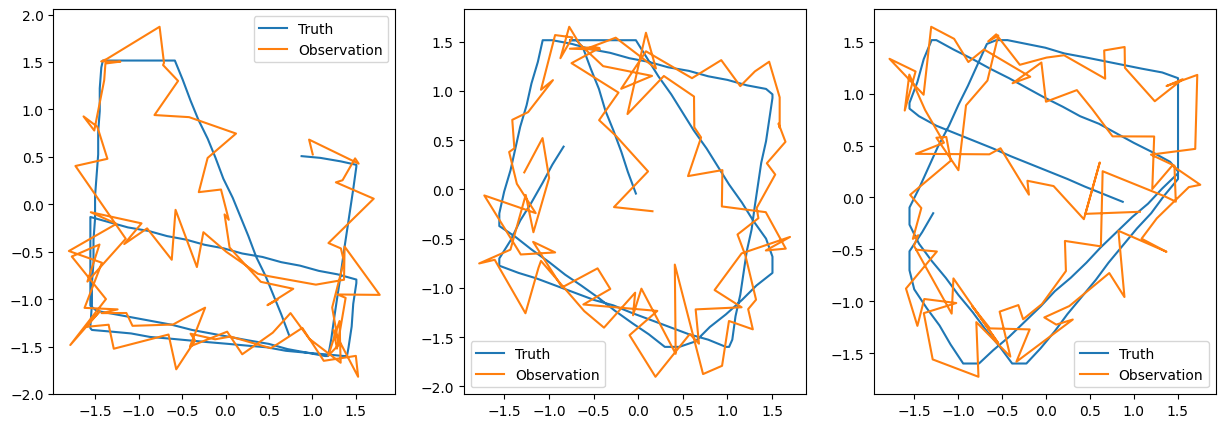

In [5]:
data_dir = "/home/james/projects/master_project/svae-control/src/svae_control/data/"
latents = np.load(os.path.join(data_dir, "cifar_latents.npy"))
controls = np.load(os.path.join(data_dir, "cifar_controls.npy"))

# make observations as noisy locations
key = jr.PRNGKey(2002)
observations = latents[:, :, :2]
observations += + jr.normal(key, shape=observations.shape) * 0.1

# standardise
N = 200
train_X, val_X = observations[:N], observations[N:]
train_Y, val_Y = latents[:N], latents[N:]

train_X, val_X = standardize(train_X, val_X)
train_Y, val_Y = standardize(train_Y, val_Y)

# plot examples
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].plot(train_Y[i, :, 0], train_Y[i, : , 1], label="Truth")
    ax[i].plot(train_X[i, :, 0], train_X[i, : , 1], label="Observation")
    ax[i].legend()
plt.show()

GPS_train_data = InputData(obs=train_X, targets=train_Y)
GPS_val_data = InputData(obs=val_X, targets=val_Y)

In [6]:
data_dir = "/home/james/projects/master_project/svae-control/src/svae_control/data/"
latents = np.load(os.path.join(data_dir, "cifar_latents.npy"))
observations = np.load(os.path.join(data_dir, "cifar_observations.npy"))
controls = np.load(os.path.join(data_dir, "cifar_controls.npy"))

# clean observations
observations = numpy.array(observations)
observations[:, :, 1] = numpy.clip(observations[:, :, 1], -numpy.pi, numpy.pi)
observations[:, :, 3] = numpy.clip(observations[:, :, 3], -numpy.pi, numpy.pi)
observations[:, :, 5] = numpy.clip(observations[:, :, 5], -numpy.pi, numpy.pi)
observations = np.array(observations)

# standardise
N = 200
train_X, val_X = observations[:N], observations[N:]
train_Y, val_Y = latents[:N], latents[N:]

train_X, val_X = standardize(train_X, val_X)
train_Y, val_Y = standardize(train_Y, val_Y)

Beacon_train_data = InputData(obs=train_X, targets=train_Y)
Beacon_val_data = InputData(obs=val_X, targets=val_Y)

train_X.shape, train_Y.shape, val_X.shape, val_Y.shape

((200, 100, 6), (200, 100, 3), (50, 100, 6), (50, 100, 3))

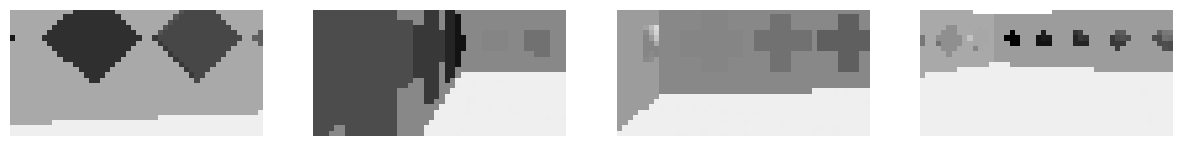

((200, 100, 24, 48), (200, 100, 3), (50, 100, 24, 48), (50, 100, 3))

In [7]:
data_dir = "/home/james/projects/master_project/svae-control/src/svae_control/data/"
latents = np.load(os.path.join(data_dir, "cifar_latents.npy"))
observations = np.load(os.path.join(data_dir, "non_cifar_greyscale_images.npy")) / 255
controls = np.load(os.path.join(data_dir, "cifar_controls.npy"))

observations = observations[:, :, 18:42, :]

# plot images before flattening 
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].imshow(observations[0, i * 30], cmap="grey", vmin=0, vmax=1)
    ax[i].axis("off")
plt.show()

# standardise
N = 200
train_X, val_X = observations[:N], observations[N:]
train_Y, val_Y = latents[:N], latents[N:]

train_X, val_X = standardize(train_X, val_X)
train_Y, val_Y = standardize(train_Y, val_Y)

Image_train_data = InputData(obs=train_X[..., None], targets=train_Y)
Image_val_data = InputData(obs=val_X[..., None], targets=val_Y) 

train_X.shape, train_Y.shape, val_X.shape, val_Y.shape

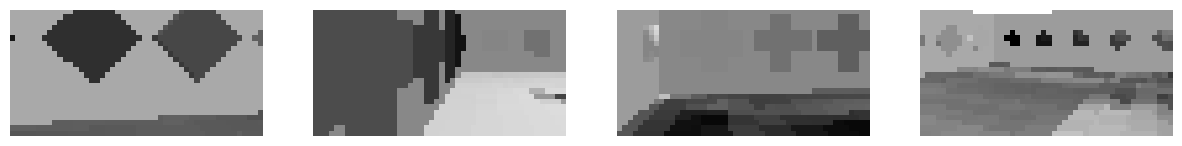

((200, 100, 24, 48), (200, 100, 3), (50, 100, 24, 48), (50, 100, 3))

In [8]:
data_dir = "/home/james/projects/master_project/svae-control/src/svae_control/data/"
latents = np.load(os.path.join(data_dir, "cifar_latents.npy"))
observations = np.load(os.path.join(data_dir, "cifar_greyscale_images.npy")) / 255
controls = np.load(os.path.join(data_dir, "cifar_controls.npy"))

observations = observations[:, :, 18:42, :]

# plot images before flattening 
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].imshow(observations[0, i * 30], cmap="grey", vmin=0, vmax=1)
    ax[i].axis("off")
plt.show()

# standardise
N = 200
train_X, val_X = observations[:N], observations[N:]
train_Y, val_Y = latents[:N], latents[N:]

train_X, val_X = standardize(train_X, val_X)
train_Y, val_Y = standardize(train_Y, val_Y)

C_Image_train_data = InputData(obs=train_X[..., None], targets=train_Y)
C_Image_val_data = InputData(obs=val_X[..., None], targets=val_Y) 

train_X.shape, train_Y.shape, val_X.shape, val_Y.shape

In [33]:
SEEDS = {
    "noisy_locations": 2,
    "sensor_observations": 2,
    "image_observations": 1,
    "corrupted_image_observations": 2,
}
DATA = {
    "noisy_locations": (GPS_train_data, GPS_val_data),
    "sensor_observations": (Beacon_train_data, Beacon_val_data),
    "image_observations": (Image_train_data, Image_val_data),
    "corrupted_image_observations": (C_Image_train_data, C_Image_val_data),
}
PLOT_TITLES = {
    "noisy_locations": "GPS",
    "sensor_observations": "Beacon",
    "image_observations": "Image",
    "corrupted_image_observations": "Corrupted Image",
}

In [34]:
def run_image_krr(train_X, val_X, train_Y, val_Y, apply, trainer):

    train_ts_means = []
    for i in tqdm(range(train_X.shape[0]), desc=f"Getting Train Posterior Means for Seed {seed}"):
        train_ts_means.append(apply(trainer.params, train_X[None, i]).smoothed_means)
        
    val_ts_means = []
    for j in tqdm(range(val_X.shape[0]), desc=f"Getting Val Posterior Means for Seed {seed}"):
        val_ts_means.append(apply(trainer.params, val_X[None, j]).smoothed_means)
    
    train_ts_means = np.concat(train_ts_means)
    val_ts_means = np.concat(val_ts_means)
    
    # standardize the posterior means output
    train_ts_means, val_ts_means = standardize(train_ts_means, val_ts_means)
    sigma_range = np.arange(0.01, 5, 0.25)
    lambda_range = np.arange(0.001, 0.5, 0.05)
    krr, aux = sweep_krr(train_ts_means, train_Y, val_ts_means, val_Y, sigma_range, lambda_range, batch_frac=0.5)
    
    return krr, aux, val_ts_means


def run_krr(train_X, val_X, train_Y, val_Y, apply, trainer):
    
    train_ts_means = apply(trainer.params, train_X).smoothed_means
    val_ts_means = apply(trainer.params, val_X).smoothed_means
    
    # standardize the posterior means output
    train_ts_means, val_ts_means = standardize(train_ts_means, val_ts_means)
    sigma_range = np.arange(0.01, 5, 0.25)
    lambda_range = np.arange(0.001, 1, 0.1)
    krr, aux = sweep_krr(train_ts_means, train_Y, val_ts_means, val_Y, sigma_range, lambda_range, batch_frac=0.5)

    return krr, aux, val_ts_means

Using seed:  2



itting KRR: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.72s/it]

Using seed:  2



itting KRR: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.71s/it]

Using seed:  1





itting KRR: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.75s/it]

Using seed:  2





itting KRR: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.80s/it]

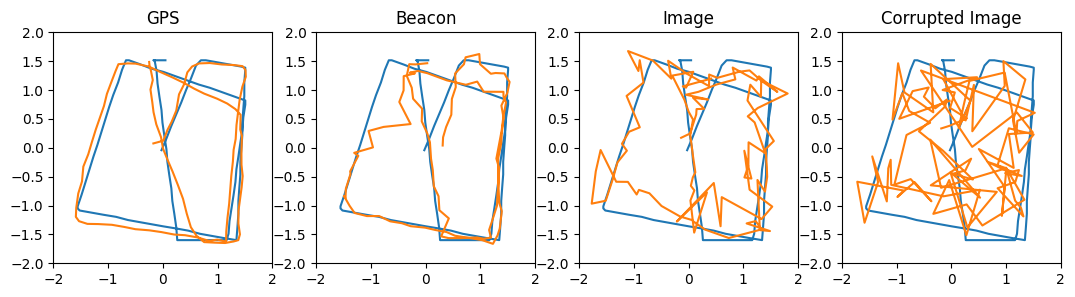

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(13, 3))

i = 0

for path, seed in SEEDS.items():

    train_data, val_data = DATA[path]

    # Load config with specific seed
    cfg_name = "noisy_observations" if path == "noisy_locations" else path
    config_dir = f"{FOLDER_LOCATION}/{path}/{cfg_name}_config_seed_{seed}.yaml"
    yaml_config = Path(config_dir)
    config = Config.from_yaml(yaml_config)
    print("Using seed: ", config.training.seed)

    # generate keys using seed
    key = jr.PRNGKey(config.training.seed)
    data_key, model_key, trainer_key = jr.split(key, 3)

    # to be safe, redefine prior and enc/dec networks for each seed
    prior = LDSParams.init(config.model.latent_dim)
    enc = getattr(network, config.model.encoder.dist_type)(
        config.model.encoder, config.model.latent_dim
    )
    dec = getattr(network, config.model.decoder.dist_type)(
        config.model.decoder, config.data.obs_dim_flat
    )
    
    model = SVAE(
        generation_network=dec, recognition_network=enc, config=config, key=model_key
    )
    trainer = Trainer(
        model=model,
        config=config,
        prior_params=prior,
        beta_schedule=get_beta_schedule(config.training.beta),
        key=trainer_key,
        logger=None,
    )

    # load params
    filename = f"{FOLDER_LOCATION}/{path}/params/svae_params_seed_{seed}.pkl"
    with open(filename, 'rb') as f:
        params = pickle.load(f)
    trainer.params = params
    
    apply = vmap(model.apply, (None, 0))

    if "image" in path:
        krr, aux, val_X = run_image_krr(train_data.obs, val_data.obs, train_data.targets, val_data.targets, apply, trainer)
    
    else: 
        krr, aux, val_X = run_krr(train_data.obs, val_data.obs, train_data.targets, val_data.targets, apply, trainer)

    krr_preds = krr.predict(val_X)
    ax[i].plot(val_data.targets[0, :, 0], val_data.targets[0, :, 1], label="Truth")
    ax[i].plot(krr_preds[0, :, 0], krr_preds[0, :, 1], label="KRR Preds")
    ax[i].set_xlim(-2, 2)
    ax[i].set_ylim(-2, 2)
    ax[i].set_title(PLOT_TITLES[path])
    # ax[i].legend()

    i += 1
    
plt.savefig("svae_qualitative_trajectories.png")
plt.show()